# UAS Obstacle Avoidance Integrating Safety Bound with Reinforcement Learning
Author: Jueming Hu, Arizona State University

Email: jueming.hu@asu.edu

This module demonstrates UAS obstacle avoidance with a risk-based safety bound using reinforcement learning. 

The detailed information can be found [here](https://arc.aiaa.org/doi/abs/10.2514/6.2020-1372)

## Code Requirements

This code has been tested under python 3.7

In [2]:
import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import pygame
from matplotlib import colors
import matplotlib.pyplot as plt
from collections import defaultdict
from multiPoly_bound import CliffWalkingEnv
from multiPoly_bound import polysize1
from multiPoly_bound import polysize2
from multiPoly_bound import polysize3
from multiPoly_bound import polysize4
import plotting

if "../" not in sys.path:
  sys.path.append("../") 
matplotlib.style.use('ggplot')

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Environment setup

In [ ]:
origin1 = (49, 0)
des=(0, 49)
env = CliffWalkingEnv(origin1, des)

### Reinforcement Learning Algorithm

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn



def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    margin = 1
    w = 10
    trajectories = []
    for i_episode in range(num_episodes):
        print(i_episode)
        epsilon = 1 / (i_episode+1)
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        # Print out which episode
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        pp = []
        aa = []
        rr = []
        pp.append(int(np.ravel_multi_index(origin1,(50, 50))))
        rr.append(-4*np.sqrt(2))
        for t in itertools.count():
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            aa.append(action) 
            next_state, reward, done, _ = env.step(action)
            rr.append(reward)
            pp.append(int(next_state))

            next_position = np.unravel_index(next_state, (50, 50))
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            if done:
                aa.append(int(0))
                break
                
            state = next_state
        trajectory = []
        trajectory.append([[pp[i], aa[i], rr[i]] for i in range(len(aa))])
        trajectory = np.array(trajectory)
        trajectory = trajectory.reshape(trajectory.shape[1], trajectory.shape[2])
        if i_episode > 2998:
            trajectories.append(trajectory)

    return Q, stats, np.array(trajectories)

### Result Visualization

In [5]:
def trajectory(point, matrix, poly1, poly2, poly3, poly4):
    cmap = colors.ListedColormap(['white', 'red','black'])
    data = np.zeros(matrix)
    for i in range(len(point)):
        ax = plt.gca()
        data[np.unravel_index(point[i], matrix)] = 1
        data[poly1[0]:poly1[1]+1, poly1[2]:poly1[3]+1] = 2
        data[poly2[0]:poly2[1]+1, poly2[2]:poly2[3]+1] = 2
        data[poly3[0]:poly3[1]+1, poly3[2]:poly3[3]+1] = 2
        data[poly4[0]:poly4[1]+1, poly4[2]:poly4[3]+1] = 2

        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.5)
        ax.set_xticks(np.arange(-.5, matrix[0], 1));
        ax.set_yticks(np.arange(-.5, matrix[1], 1));
        ax.grid(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.imshow(data, cmap=cmap)

        #plt.show()
        # ax.figure.savefig('picture_multiPoly_withBound/pic_' + str(i) + '.png')


### Example

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Episode 100/3000.100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Episode 200/3000.200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268


Episode 1800/3000.1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
Episode 1900/3000.1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992

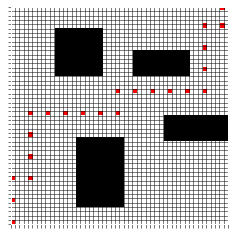

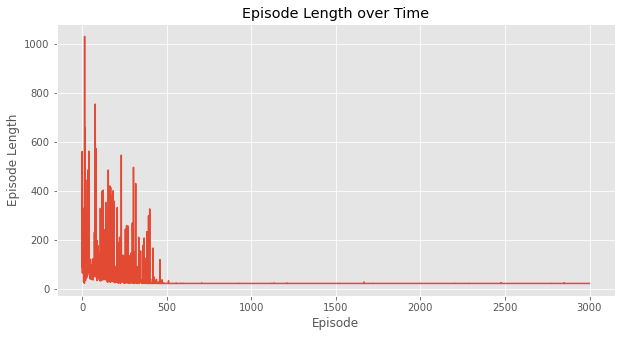

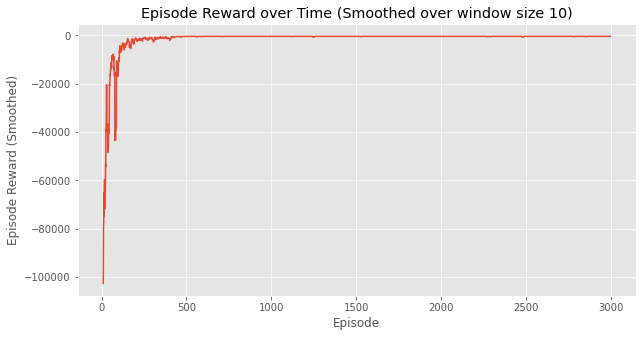

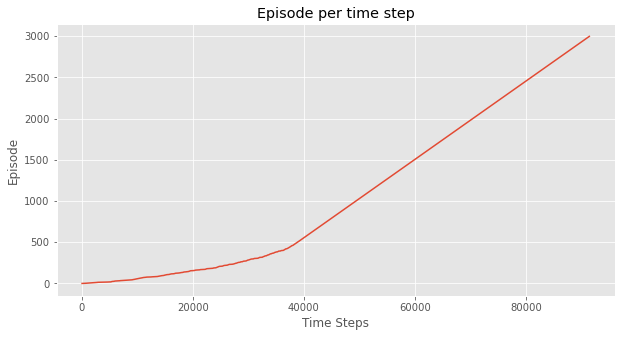

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [6]:
# main 

# train the agent
Q, stats, trajectories = q_learning(env, 3000)

# save the last episode
with open('multiPoly_withbound.txt', 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(trajectories.shape))
    for data_slice in trajectories:
        np.savetxt(outfile, data_slice, fmt='%-7.2f')
        outfile.write('# New slice\n')

# trajectory visualization
# show the agent's position at each time step
trajectories = np.loadtxt('multiPoly_withbound.txt')
trajectories = trajectories.astype(int)
trajectories = trajectories.reshape((1, 23, 3))
trajectory(trajectories[0,:,0], (50,50), polysize1, polysize2, polysize3, polysize4)

# RL learning curve 
plotting.plot_episode_stats(stats)